core

In [1]:
"""The classes in this file define the firecrown-CCL API.

Some Notes:

 - Each subclass which inherits from a given class is expected to define any
   methods defined in the parent with the same call signature. See the base
   class docstrings for additional instructions.
 - If a base class includes a class-level doc string, then
   the `__init__` function of the subclass should define at least those
   arguments and/or keyword arguments in the class-level doc string.
 - Attributes ending with an underscore are set after the call to
   `apply`/`compute`/`render`.
 - Attributes define in the `__init__` method should be considered constant
   and not changed after instantiation.
 - Objects inheriting from `Systematic` should only adjust source/statistic
   properties ending with an underscore.
 - The `read` methods are called after all objects are made and are used to
   read any additional data.
"""
import numpy as np


class Statistic(object):
    """A statistic (e.g., two-point function, mass function, etc.).

    Parameters
    ----------
    sources : list of str
        A list of the sources needed to compute this statistic.
    systematics : list of str, optional
        A list of the statistics-level systematics to apply to the statistic.
        The default of `None` implies no systematics.
    """
    def read(self, sacc_data, sources):
        """Read the data for this statistic from the SACC file.

        Parameters
        ----------
        sacc_data : sacc.Sacc
            The data in the sacc format.
        sources : dict
            A dictionary mapping sources to their objects. These sources do
            not have to have been rendered.
        """
        pass

    def compute(self, cosmo, params, sources, systematics=None):
        """Compute a statistic from sources, applying any systematics.

        Parameters
        ----------
        cosmo : pyccl.Cosmology
            A pyccl.Cosmology object.
        params : dict
            A dictionary mapping parameter names to their current values.
        sources : dict
            A dictionary mapping sources to their objects. The sources must
            already have been rendered by calling `render` on them.
        systematics : dict
            A dictionary mapping systematic names to their objects. The
            default of `None` corresponds to no systematics.
        """
        raise NotImplementedError(
            "Method `compute` is not implemented!")


class Systematic(object):
    """The systematic (e.g., shear biases, photo-z shifts, etc.)."""
    def apply(self, cosmo, params, source_or_statistic):
        """Apply systematics to a source.

        Parameters
        ----------
        cosmo : pyccl.Cosmology
            A pyccl.Cosmology object.
        params : dict
            A dictionary mapping parameter names to their current values.
        source_or_statistic : a source or statistic object
            The source or statistic to which apply systematics.
        """
        raise NotImplementedError(
            "Method `apply` is not implemented!")


class Source():
    """The source (e.g., a sample of lenses).

    Parameters
    ----------
    scale : 1.0, optional
        The default scale for this source.
    systematics : list of str, optional
        A list of the source-level systematics to apply to the source. The
        default of `None` implies no systematics.
    """
    def read(self, sacc_data):
        """Read the data for this source from the SACC file.

        Parameters
        ----------
        sacc_data : sacc.Sacc
            The data in the sacc format.
        """
        pass

    def render(self, cosmo, params, systematics=None):
        """Render a source by applying systematics.

        This method should compute the final scale factor for the source
        as `scale_` and then apply any systematics.

        Parameters
        ----------
        cosmo : pyccl.Cosmology
            A pyccl.Cosmology object.
        params : dict
            A dictionary mapping parameter names to their current values.
        systematics : dict, optional
            A dictionary mapping systematic names to their objects. The
            default of `None` corresponds to no systematics.
        """
        raise NotImplementedError(
            "Method `render` is not implemented!")


class LogLike(object):
    """The log-likelihood (e.g., a Gaussian, T-distribution, etc.).

    Parameters
    ----------
    data_vector : list of str
        A list of the statistics in the config file in the order you want them
        to appear in the covariance matrix.

    Attributes
    ----------
    cov : array-like, shape (n, n)
        The covariance matrix for the data vector.
    inv_cov : array-like, shape (n, n)
        The inverse of the covariance matrix.
    """
    def read(self, sacc_data, sources, statistics):
        """Read the covariance matrirx for this likelihood from the SACC file.

        Parameters
        ----------
        sacc_data : sacc.Sacc
            The data in the sacc format.
        sources : dict
            A dictionary mapping sources to their objects. These sources do
            not have to have been rendered.
        statistics : dict
            A dictionary mapping statistics to their objects. These statistics do
            not have to have been rendered.
        """
        pass

    def compute(self, data, theory, **kwargs):
        """Compute the log-likelihood.

        Parameters
        ----------
        data : dict of arrays
            A dictionary mapping the names of the statistics to their
            values in the data.
        theory : dict of arrays
            A dictionary mapping the names of the statistics to their
            predictions.
        **kwargs : extra keyword arguments
            Any extra keyword arguments can be used by subclasses.

        Returns
        -------
        loglike : float
            The log-likelihood.
        """
        raise NotImplementedError(
            "Method `compute_loglike` is not implemented!")

    def assemble_data_vector(self, data):
        """Compute the log-likelihood.

        Parameters
        ----------
        data : dict of arrays
            A dictionary mapping the names of the statistics to their
            values.

        Returns
        -------
        data_vector : array-like
            The data vector.
        """
        dv = []
        for stat in self.data_vector:
            dv.append(np.atleast_1d(data[stat]))
        return np.concatenate(dv, axis=0)

In [31]:
import copy
import functools
import warnings
import healpy as hp
import numpy as np
import pyccl as ccl

source

In [59]:
import numpy as np
from scipy.interpolate import Akima1DInterpolator

import pyccl as ccl




__all__ = ['WLSource', 'NumberCountsSource', 'ClusterSource', 'CMBLsource']


class WLSource(Source):

    def __init__(
            self, sacc_tracer, ia_bias=None, scale=1.0, systematics=None):
        self.sacc_tracer = sacc_tracer
        self.ia_bias = ia_bias
        self.systematics = systematics or []
        self.scale = scale

    def read(self, sacc_data):

        tracer = sacc_data.get_tracer(self.sacc_tracer)
        z = getattr(tracer, 'z').copy().flatten()
        nz = getattr(tracer, 'nz').copy().flatten()
        inds = np.argsort(z)
        z = z[inds]
        nz = nz[inds]
        self.z_orig = z
        self.dndz_orig = nz
        self.dndz_interp = Akima1DInterpolator(self.z_orig, self.dndz_orig)

    def render(self, cosmo, params, systematics=None):

        systematics = systematics or {}

        self.z_ = self.z_orig.copy()
        self.dndz_ = self.dndz_orig.copy()
        self.scale_ = self.scale
        if self.ia_bias is not None:
            self.ia_bias_ = np.ones_like(self.z_) * params[self.ia_bias]

        for systematic in self.systematics:
            systematics[systematic].apply(cosmo, params, self)

        if self.ia_bias is not None:
            tracer = ccl.WeakLensingTracer(
                cosmo,
                dndz=(self.z_, self.dndz_),
                ia_bias=(self.z_, self.ia_bias_))
        else:
            tracer = ccl.WeakLensingTracer(
                cosmo,
                dndz=(self.z_, self.dndz_))
        self.tracer_ = tracer


class NumberCountsSource(Source):

    def __init__(
            self, sacc_tracer, bias, has_rsd=False,
            mag_bias=None, scale=1.0, systematics=None):
        self.sacc_tracer = sacc_tracer
        self.bias = bias
        self.has_rsd = has_rsd
        self.mag_bias = mag_bias
        self.systematics = systematics or []
        self.scale = scale

    def read(self, sacc_data):
        
        tracer = sacc_data.get_tracer(self.sacc_tracer)
        z = getattr(tracer, 'z').copy().flatten()
        nz = getattr(tracer, 'nz').copy().flatten()
        inds = np.argsort(z)
        z = z[inds]
        nz = nz[inds]
        self.z_orig = z
        self.dndz_orig = nz
        self.dndz_interp = Akima1DInterpolator(self.z_orig, self.dndz_orig)

    def render(self, cosmo, params, systematics=None):

        systematics = systematics or {}

        self.z_ = self.z_orig.copy()
        self.dndz_ = self.dndz_orig.copy()
        self.scale_ = self.scale
        self.bias_ = np.ones_like(self.z_) * params[self.bias]

        if self.mag_bias is not None:
            self.mag_bias_ = np.ones_like(self.z_) * params[self.mag_bias]

        for systematic in self.systematics:
            systematics[systematic].apply(cosmo, params, self)

        if self.mag_bias is not None:
            tracer = ccl.NumberCountsTracer(
                cosmo,
                has_rsd=self.has_rsd,
                dndz=(self.z_, self.dndz_),
                bias=(self.z_, self.bias_),
                mag_bias=(self.z_, self.mag_bias_))
        else:
            tracer = ccl.NumberCountsTracer(
                cosmo,
                has_rsd=self.has_rsd,
                dndz=(self.z_, self.dndz_),
                bias=(self.z_, self.bias_))
        self.tracer_ = tracer


class CMBLSource(Source):
    def __init__(self, sacc_tracer, scale=1.0, systematics=None):
        self.sacc_tracer = sacc_tracer
        self.scale = scale
        self.systematics = systematics or []
        
    def read(self, sacc_data):
        tracer = sacc_data.get_tracer(self.sacc_tracer)
        ell = getattr(tracer, 'ell').copy().flatten()
        beam = getattr(tracer, 'beam').copy().flatten()
        inds = np.argsort(ell)
        ell = ell[inds]
        beam = beam[inds]
        self.ell_orig = ell
        self.beam_orig = beam
        
    def render(self, cosmo, params, systematics=None):
        systematics = systematics or {}
        
        for systematic in self.systematics:
            systematics[systematic].apply(cosmo, params, self)

        tracer = ccl.CMBLensingTracer(cosmo,1100.)
        self.tracer_ = tracer
        self.scale_ = self.scale
        

2 point

In [10]:
import copy
import functools
import warnings

import numpy as np
import pyccl as ccl

# only supported types are here, any thing else will throw
# a value error
SACC_DATA_TYPE_TO_CCL_KIND = {
    "galaxy_density_cl": 'cl',
    "galaxy_density_xi": 'gg',
    "galaxy_shearDensity_cl_e": 'cl',
    "galaxy_shearDensity_xi_t": 'gl',
    "galaxy_shear_cl_ee": 'cl',
    "galaxy_shear_xi_minus": 'l-',
    "galaxy_shear_xi_plus": 'l+',
    "cmbGalaxy_convergenceDensity_xi": 'gg',
}


ELL_FOR_XI_DEFAULTS = dict(min=2, mid=50, max=6e4, n_log=200)


def _ell_for_xi(*, min, mid, max, n_log):
    """Build an array of ells to sample the power spectrum for real-space
    predictions.
    """
    return np.concatenate((
        np.linspace(min, mid-1, mid-min),
        np.logspace(np.log10(mid), np.log10(max), n_log)))


def _generate_ell_or_theta(*, min, max, n, binning='log'):
    if binning == 'log':
        edges = np.logspace(np.log10(min), np.log10(max), n+1)
        return np.sqrt(edges[1:] * edges[:-1])
    else:
        edges = np.linspace(min, max, n+1)
        return (edges[1:] + edges[:-1]) / 2.0


@functools.lru_cache(maxsize=128)
def _cached_angular_cl(cosmo, tracers, ells):
    return ccl.angular_cl(cosmo, *tracers, np.array(ells))


class TwoPointStatistic(Statistic):

    def __init__(self, sacc_data_type, sources, systematics=None,
                 ell_for_xi=None, ell_or_theta=None, ell_or_theta_min=None,
                 ell_or_theta_max=None):
        self.sacc_data_type = sacc_data_type
        self.sources = sources
        self.systematics = systematics or []
        self.ell_for_xi = copy.deepcopy(ELL_FOR_XI_DEFAULTS)
        if ell_for_xi is not None:
            self.ell_for_xi.update(ell_for_xi)
        self.ell_or_theta = ell_or_theta
        self.ell_or_theta_min = ell_or_theta_min
        self.ell_or_theta_max = ell_or_theta_max

        if self.sacc_data_type in SACC_DATA_TYPE_TO_CCL_KIND:
            self.ccl_kind = SACC_DATA_TYPE_TO_CCL_KIND[self.sacc_data_type]
        else:
            raise ValueError(
                "The SACC data type '%s' is not supported!" % sacc_data_type)

        if len(sources) != 2:
            raise ValueError(
                "A firecrown 2pt statistic should only have two "
                "sources, you sent '%s'!" % self.sources)

    def read(self, sacc_data, sources):

        tracers = [sources[src].sacc_tracer for src in self.sources]
        if len(tracers) != 2:
            raise RuntimeError(
                "A firecrown 2pt statistic should only have two "
                "tracers, you sent '%s'!" % self.sources)

        # sacc is tracer order sensitive
        # so we try again if we didn't find anything
        for order in [1, -1]:
            tracers = tracers[::order]

            if self.ccl_kind == 'cl':
                _ell_or_theta, _stat = sacc_data.get_ell_cl(
                    self.sacc_data_type, *tracers, return_cov=False)
            else:
                _ell_or_theta, _stat = sacc_data.get_theta_xi(
                    self.sacc_data_type, *tracers, return_cov=False)

            if len(_ell_or_theta) > 0 and len(_stat) > 0:
                break

        if self.ell_or_theta is None and (len(_ell_or_theta) == 0 or len(_stat) == 0):
            raise RuntimeError(
                "Tracers '%s' have no 2pt data in the SACC file "
                "and no input ell or theta values were given!" % tracers)
        elif (
            self.ell_or_theta is not None
            and len(_ell_or_theta) > 0
            and len(_stat) > 0
        ):
            warnings.warn(
                "Tracers '%s' have 2pt data and you have specified `ell_or_theta` "
                "in the configuration. `ell_or_theta` is being ignored!" % tracers,
                warnings.UserWarning,
                stacklevel=2,
            )

        self.sacc_tracers = tuple(tracers)

        # at this point we default to the values in the sacc file
        if len(_ell_or_theta) == 0 or len(_stat) == 0:
            _ell_or_theta = _generate_ell_or_theta(**self.ell_or_theta)
            _stat = np.zeros_like(_ell_or_theta)
            self.sacc_inds = None
        else:
            self.sacc_inds = np.atleast_1d(sacc_data.indices(
                self.sacc_data_type,
                self.sacc_tracers))

        if self.ell_or_theta_min is not None:
            q = np.where(_ell_or_theta >= self.ell_or_theta_min)
            _ell_or_theta = _ell_or_theta[q]
            _stat = _stat[q]
            if self.sacc_inds is not None:
                self.sacc_inds = self.sacc_inds[q]

        if self.ell_or_theta_max is not None:
            q = np.where(_ell_or_theta <= self.ell_or_theta_max)
            _ell_or_theta = _ell_or_theta[q]
            _stat = _stat[q]
            if self.sacc_inds is not None:
                self.sacc_inds = self.sacc_inds[q]

        # I don't think we need these copies, but being safe here.
        self._ell_or_theta = _ell_or_theta.copy()
        self._stat = _stat.copy()

    def compute(self, cosmo, params, sources, systematics=None):

        self.ell_or_theta_ = self._ell_or_theta.copy()

        tracers = [sources[k].tracer_ for k in self.sources]
        self.scale_ = np.prod([sources[k].scale_ for k in self.sources])

        if self.ccl_kind == 'cl':
            self.predicted_statistic_ = _cached_angular_cl(
                cosmo, tuple(tracers), tuple(self.ell_or_theta_.tolist())
            ) * self.scale_
        else:
            ells = _ell_for_xi(**self.ell_for_xi)
            cells = _cached_angular_cl(
                cosmo, tuple(tracers), tuple(ells.tolist()))
            self.predicted_statistic_ = ccl.correlation(
                cosmo, ells, cells, self.ell_or_theta_ / 60,
                corr_type=self.ccl_kind) * self.scale_

        systematics = systematics or {}
        for systematic in self.systematics:
            systematics[systematic].apply(cosmo, params, self)

        if not hasattr(self, '_stat'):
            self.measured_statistic_ = self.predicted_statistic_
        else:
            self.measured_statistic_ = self._stat.copy()

In [49]:
fname = '/global/u1/z/zhzhuoqi/MCMC/sacc/NK20-40.fits'

In [50]:
import sacc
s = sacc.Sacc.load_fits(fname)

In [51]:
cosmo=ccl.Cosmology(Omega_c=0.21, Omega_b=0.045, Omega_g=0, Omega_k=0,
                              h=0.71, sigma8=0.80, n_s=0.964, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker')
param = dict({'Omega_c':0.21, 'Omega_b':0.045, 'h':0.71, 'sigma8':0.80, 'n_s':0.964, 'bias':1})

In [60]:
CMBsource = CMBLSource('ck')
CMBsource.read(s)
CMBsource.render(cosmo, param)

In [53]:
NCsource = NumberCountsSource('gc', 'bias')
NCsource.read(s)
NCsource.render(cosmo, param)

In [54]:
source_dict = dict({'cmb':CMBsource, 'nc':NCsource})
sources = ['cmb','nc']

In [55]:
NK = TwoPointStatistic('cmbGalaxy_convergenceDensity_xi', sources, ell_for_xi=ELL_FOR_XI_DEFAULTS )

In [56]:
NK.read(s, source_dict)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/sacc/sacc.py:368: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


In [57]:
NK.compute(cosmo, param, source_dict, systematics=None)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/pyccl/correlation.py:83: CCLWarning: corr_type is deprecated. Use type = NN
  CCLWarning)


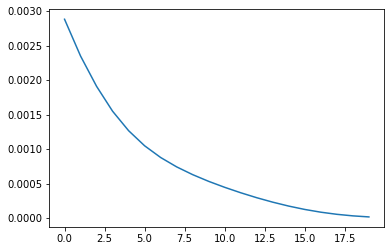

In [58]:
import matplotlib.pyplot as plt
plt.plot(NK.predicted_statistic_)

In [35]:
theta_deg = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/map1/all_bins/NK/data/theta_deg.txt')

z = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/map1/all_bins/NK/data/z20-40.txt')
z_h = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/map1/all_bins/NK/data/z_h20-40.txt')


ells = np.linspace(2, 3000, 2999).astype(int)

# Limber prefactors
lf_dl = (ells+0.5)**2/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))
lf_dc = (ells+0.5)**2/(ells*(ells+1.))
lf_ll = ells*(ells+1.)/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))


def correlation(theta_deg, z, z_h): 
    
    #generate bias
    bz=1*np.ones_like(z_h)

    # Initialize tracers  
    cosmo_cls=ccl.Cosmology(Omega_c=0.21, Omega_b=0.045, Omega_g=0, Omega_k=0,
                              h=0.71, sigma8=0.80, n_s=0.964, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker')
    cosmo_cls.cosmo.gsl_params.INTEGRATION_LIMBER_EPSREL = 1E-4
    cosmo_cls.cosmo.gsl_params.INTEGRATION_EPSREL = 1E-4   

    #generate tracers 
    trcrs={}
    trcrs['nc']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,dndz=(z,z_h),bias=(z,bz))
    trcrs['cmbl']=ccl.CMBLensingTracer(cosmo_cls,1100.)

    #CCL Power spectra
    cl_ccl={}
    cl_ccl['nc/cmbl']=ccl.angular_cl(cosmo_cls,trcrs['nc'],trcrs['cmbl'],ells)*lf_dc

    win = hp.pixwin(4096)[:2999]
    cl_ccl['nc/cmbl'] = cl_ccl['nc/cmbl']*win

    #generate correlations from power spectrum 
    ell = ells
    cell = cl_ccl['nc/cmbl']
    corr = ccl.correlation(cosmo_cls, ell, cell, theta_deg, corr_type='GG', method='FFTLog')
 
    return corr

In [36]:
corr_ccl = correlation(theta_deg, z, z_h)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/pyccl/correlation.py:83: CCLWarning: corr_type is deprecated. Use type = NN
  CCLWarning)


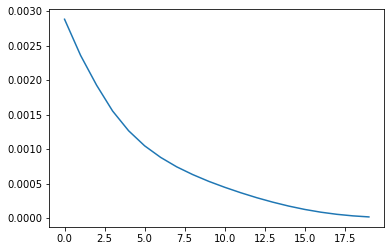

In [37]:
plt.plot(corr_ccl)

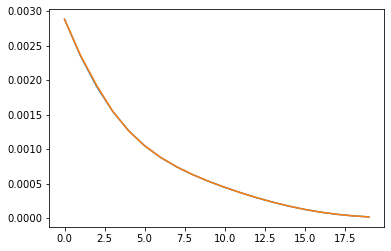

In [61]:
plt.plot(NK.predicted_statistic_)
plt.plot(corr_ccl)